# QCoDeS Example with Keysight E4980A LCR meter

This example is following the "Capacitor Measurements" on P215 of the user's guide: https://literature.cdn.keysight.com/litweb/pdf/E4980-90230.pdf?id=789356

A 8400 pF (8E-9 F) leaded ceramic capacitor is connected to the LCR meter.

In [1]:
import numpy as np
import time
from qcodes.dataset import initialise_database, Measurement, new_experiment
from qcodes.dataset.plotting import plot_by_id

from qcodes.instrument_drivers.Keysight.keysight_e4980a import KeysightE4980A, E4980AMeasurements

In [2]:
meter = KeysightE4980A("lcr_e4980a", 'USB0::0x2A8D::0x2F01::MY46618801::INSTR')

Connected to: Keysight Technologies E4980A (serial:MY46618801, firmware:B.07.05) in 0.09s


In [3]:
meter.IDN()

{'vendor': 'Keysight Technologies',
 'model': 'E4980A',
 'serial': 'MY46618801',
 'firmware': 'B.07.05'}

In [4]:
meter.reset()

### Step 1. Set up the E4980A’s measurement conditions:

1. set frequency to be 1MHz (system default is 1kHz)

2. set the voltage level to be 1.5 V (system default is 1V)

In [5]:
meter.frequency(1e6)
freq = meter.frequency()
print(f'The frequency for normal measurement is set to be {freq/1e6} MHz.')

The frequency for normal measurement is set to be 1.0 MHz.


In [6]:
meter.voltage_level(1.5)
volt_lv = meter.voltage_level()
print(f'the voltage for measurement signal is set to be {volt_lv} V.')

the voltage for measurement signal is set to be 1.5 V.


### Step 2. (optional) Set up the corrections for the unit

In the "Capacitor Measurements" example, a Keysight 16047E Direct Couple Test Fixture (general purpose) was used. To compensate for its residuals and strays, an OPEN/SHORT correction is required.

However, for our setup with a leaded ceramic capacitor, this step may not be necessary.

In [7]:
meter.correction.open()
meter.correction.open_state('on')
meter.correction.short()
meter.correction.short_state('on')

### step 3. Set the meausurement function.

User should chose one function from the follow list, for example "**E4980AMeasurements.CPD**".

    "CPD": "Capacitance - Dissipation factor",  (by default)
    "CPQ": "Capacitance - Quality factor",
    "CPG": "Capacitance - Conductance",
    "CPRP": "Capacitance - Resistance",
    "CSD": "Capacitance - Dissipation factor",
    "CSQ": "Capacitance - Quality factor",
    "CSRS": "Capacitance - Resistance",
    "LPD": "Inductance - Dissipation factor",
    "LPQ": "Inductance - Quality factor",
    "LPG": "Inductance - Conductance",
    "LPRP": "Inductance - Resistance",
    "LPRD": "Inductance - DC resistance",
    "LSD": "Inductance - Dissipation factor",
    "LSQ": "Inductance - Quality factor",
    "LSRS": "Inductance - Resistance",
    "LSRD": "Inductance - DC resistance",
    "RX": "Resistance - Reactance",
    "ZTD": "Absolute value of impedance - Theta in degree",
    "ZTR": "Absolute value of impedance - Theta in radiant",
    "GB": "Conductance - Susceptance",
    "YTD": "Absolute value of admittance - Theta in degree",
    "YTR": "Absolute value of admittance - Theta in radiant",
    "VDID": "DC voltage - DC current"

Note: 
1. CP vs CS: ***P*** means measured using parallel equivalent circuit model, and ***S*** means measured using series equivalent circuit model.
2. Same for LP and LS
3. RP vs RS: Equivalent ***p***arallel/***s***eries resistance

By default, the measurement function is "CPD", Capacitance - Dissipation factor:

In [8]:
meter.measurement_function()

'CPD'

Take measurement:

In [9]:
data = meter.measure()

The type of "data" is "MeasurementPair", a subclass of QCoDeS' "MultiParameter" class, which includes a pair of values:

In [10]:
type(data)

qcodes.instrument_drivers.Keysight.keysight_e4980a.MeasurementPair

In [11]:
print(f'The measurement "{data.name}" returns values {data.get()}')
print(f'for parameters {data.names}')
print(f'with units {data.units}')

The measurement "CPD" returns values (-8.35219e-09, -0.00183439)
for parameters ('capacitance', 'dissipation_factor')
with units ('F', '')


User may also directly call the name of the physics parameters: (can't call the unit this way though)

In [12]:
print(f'The capacitance is measured to be {data.capacitance}')
print(f'The dissipation_factor is measured to be {data.dissipation_factor}')

The capacitance is measured to be -8.35219e-09
The dissipation_factor is measured to be -0.00183439


To change to another measurement function, for example, "LPD" for Inductance measurement:

In [13]:
meter.measurement_function(E4980AMeasurements.LPD)
meter.measurement_function()

'LPD'

In [14]:
data = meter.measure()

In [15]:
print(f'The measurement "{data.name}" returns values {data.get()}')
print(f'for parameters {data.names}')
print(f'with units {data.units}')

The measurement "LPD" returns values (3.03277e-06, -0.00183439)
for parameters ('inductance', 'dissipation_factor')
with units ('H', '')


Any "MeasurementPair" object, when first initialized, will dynamically generate the corresponding attributes. For the LPD measurement, the "data" object will have attributes "inductance" instead of "capacitance":

In [16]:
data.inductance

3.03277e-06

In [17]:
try:
    data.capacitance
except AttributeError as err:
    print(err)

'MeasurementPair' object has no attribute 'capacitance'


To validate the measurement, we can measure the impedance, and calculate the capacitance.

For a capacitor, we have Zc = - j / (2 * Pi * f * C), where Zc is the impedance of the capacitor, f is the frequency, and C is the capacitance.

There are actually two methods to measure the impedance:
1. to use the "measurement_function" method as above, and choose "RX";
2. to use the "impedance()" call, which will always return impedance in complex format, Z = R + iX, where Z is impedance, R is resistance, and X is the reactance.

(The results from the two methods should be the same.)

In [18]:
meter.measurement_function(E4980AMeasurements.RX)
data = meter.measure()
print(data.names)
print(data())
print(data.units)

('resistance', 'reactance')
(-0.0349551, 19.0554)
('Ohm', 'Ohm')


In [19]:
imp = meter.impedance()
print(imp.names)
print(imp())
print(imp.units)

('resistance', 'reactance')
(-0.0349551, 19.0554)
('Ohm', 'Ohm')


To calculate the impedance: ("imp" here is also a "MeasurementPair", so user can call the resistance/reactance directly.)

In [20]:
Zc = np.sqrt(imp.resistance**2 + imp.reactance**2)
print(f"The impedance is {Zc} Ohm.")

The impedance is 19.0554320606754 Ohm.


and the capacitance:

In [21]:
C = -1/(2*np.pi*freq*Zc)
print(f"The capacitance is {C}F.")

The capacitance is -8.352208576804858e-09F.


which is the same as what we got previously using the "CPD" function:

In [22]:
meter.measurement_function(E4980AMeasurements.CPD)
data = meter.measure()
print(f"The capacitance  is {data.capacitance} F.")

The capacitance  is -8.35219e-09 F.


### To work with QCoDeS "Measurement":

In [23]:
initialise_database()
exp = new_experiment(
    name='capacitance_measurement',
    sample_name="no sample"
)

In [24]:
meas = Measurement()
meas.register_parameter(meter.frequency)
meas.register_parameter(meter.measure(), setpoints=(meter.frequency,))

In [25]:
with meas.run() as datasaver:
    for freq in np.linspace(1.0E6, 1.5E6, 5):
        meter.frequency(freq)
        time.sleep(1)
        value_pair = meter.measure().get()
        datasaver.add_result((meter.frequency, freq),
                             (meter.measure(), value_pair))
    run_id = datasaver.run_id

Starting experimental run with id: 66. 


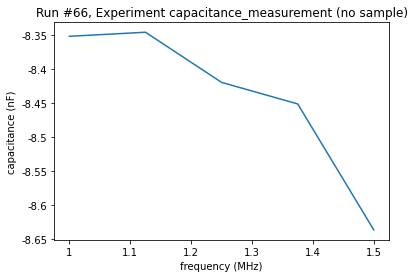

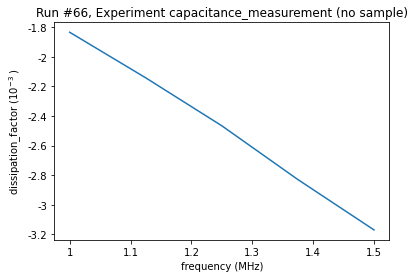

In [26]:
plot = plot_by_id(run_id)

The dataset will have two items, one for "capacitance", and the other for "dissipation_factor":

In [27]:
dataset = datasaver.dataset
dataset.get_parameter_data()

{'capacitance': {'capacitance': array([-8.35219e-09, -8.34623e-09, -8.41993e-09, -8.45158e-09,
         -8.63672e-09]),
  'lcr_e4980a_frequency': array([1000000, 1125000, 1250000, 1375000, 1500000])},
 'dissipation_factor': {'dissipation_factor': array([-0.00183439, -0.00214259, -0.00246673, -0.0028303 , -0.00317048]),
  'lcr_e4980a_frequency': array([1000000, 1125000, 1250000, 1375000, 1500000])}}

To switch to another measurement function:

In [28]:
meter.measurement_function(E4980AMeasurements.RX)
meter.measurement_function()

'RX'

which will measure the following:

In [29]:
E4980AMeasurements.RX.names

('resistance', 'reactance')

We need to re-set the measurement, and re-register parameters so that qcodes knows the correct units:

In [30]:
meas = Measurement()
meas.register_parameter(meter.frequency)
meas.register_parameter(meter.measure(), setpoints=(meter.frequency,))

In [31]:
with meas.run() as datasaver:
    for freq in np.linspace(1.0E6, 1.5E6, 5):
        meter.frequency(freq)
        time.sleep(1)
        value_pair = meter.measure().get()
        datasaver.add_result((meter.frequency, freq),
                             (meter.measure(), value_pair))
    run_id = datasaver.run_id

Starting experimental run with id: 67. 


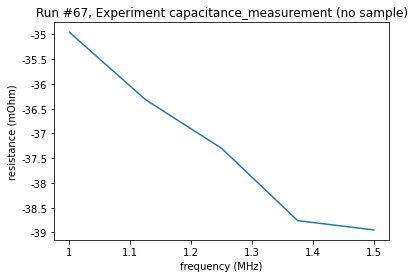

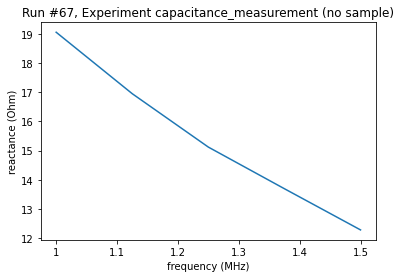

In [32]:
plot = plot_by_id(run_id)

In [33]:
meter.reset()